## Code for Ai algorithm project

### Production optimization

#### 1. Problem description

- Subject of the probem : to maximize the number of biscuits produced in the same dough.
* constraints : 
    - the roll of dough has a fixed size
    - the roll can have defects that partially usable. Their size is variable, as well as their number and position on the roll.
    - each biscuit is not limited in number in the roll
    - each biscuit has a specific size, value, and a maximum number of defects it can contain

* solution criteria : 
    - be at integer positions, so no half biscuit
    - no overlapping
    - reduce the maximum number of defect in dough as much as possible
    - do not exceed the maximum length of the roll
    - maximize the number of biscuits produced, as well as the value of the biscuits produced

* Benchmark : 
    - length = 500 units
    - set of defects : a, b and c
    - set of biscuits : 
        - biscuit 0 : len = 4, value = 6, max_defect = {a: 4, b: 2, c: 3}
        - biscuit 1 : len = 8, value = 12, max_defect = {a: 5, b: 4, c: 4}
        - biscuit 2 : len = 2, value = 1, max_defect = {a: 1, b: 2, c: 1}
        - biscuit 3 : len = 5, value = 8, max_defect = {a: 2, b: 3, c: 2}

#### Solution 1. using ortools

In [92]:
import ortools
from ortools.sat.python import cp_model

1. Problem description

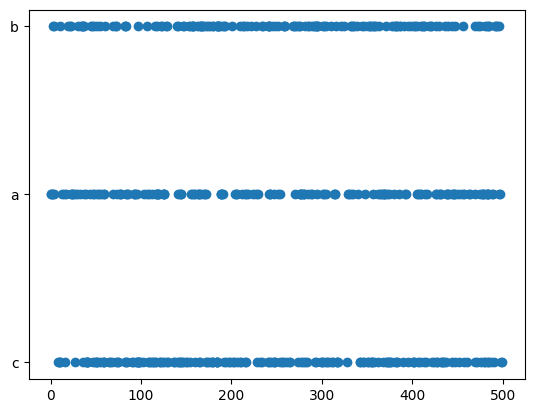

In [93]:
# importation of the defects
import pandas as pd
import matplotlib.pyplot as plt
defects = pd.read_csv("defects.csv", sep = ',')
plt.scatter(defects['x'], defects['class'])


In [94]:
defects_sorted = defects.sort_values(by='x')
print(defects_sorted.info())
print(defects_sorted.describe())
print(defects_sorted["class"].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 479 to 229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       500 non-null    float64
 1   class   500 non-null    object 
dtypes: float64(1), object(1)
memory usage: 11.7+ KB
None
                x
count  500.000000
mean   246.098987
std    143.914271
min      0.700561
25%    123.001773
50%    242.137840
75%    371.495959
max    499.403445
class
c    177
a    164
b    159
Name: count, dtype: int64


In [95]:
# we define the problem and its variables
problem = cp_model.CpModel()

# we define the variables
# -1 : no biscuit, 0 to 3 : biscuit of type 0 to 3
environnment  = [[problem.NewBoolVar(f"biscuit_no_{i}_pos_{j}")for i in range(-1,4)] for j in range(500)]
print(environnment)
# we define the constraints

# constraint 1 : the total length of the biscuit must be lower than 500 units
# maximum distance from the end
# biscuit 1 : 3
# biscuit 2 : 7
# biscuit 3 : 1
# biscuit 4 : 4
for i in range(497,500):
    problem.Add(environnment[i][1] == 0)
for i in range(492,500):
    problem.Add(environnment[i][2] == 0)
for i in range(498,500):
    problem.Add(environnment[i][3] == 0)
for i in range(495,500):
    problem.Add(environnment[i][4] == 0)

# constraint 2 : no biscuit should overlapp in the dough
for i in range(500):
   problem.Add(sum(environnment[i]) <= 1)

# constraint 3 : the biscuit criteria must be respected
for i in range(500):
    for j in range(1,4):
        if i+j < 500:  # Add this condition to prevent index out of range
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][1])
for i in range(500):
    for j in range(1,8):
        if i+j < 500:  # Add this condition to prevent index out of range
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][2])
for i in range(500):
    for j in range(1,2):
        if i+j < 500:  # Add this condition to prevent index out of range
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][3])
for i in range(500):
    for j in range(1,5):
        if i+j < 500:  # Add this condition to prevent index out of range
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][4])

    


[[biscuit_no_-1_pos_0(0..1), biscuit_no_0_pos_0(0..1), biscuit_no_1_pos_0(0..1), biscuit_no_2_pos_0(0..1), biscuit_no_3_pos_0(0..1)], [biscuit_no_-1_pos_1(0..1), biscuit_no_0_pos_1(0..1), biscuit_no_1_pos_1(0..1), biscuit_no_2_pos_1(0..1), biscuit_no_3_pos_1(0..1)], [biscuit_no_-1_pos_2(0..1), biscuit_no_0_pos_2(0..1), biscuit_no_1_pos_2(0..1), biscuit_no_2_pos_2(0..1), biscuit_no_3_pos_2(0..1)], [biscuit_no_-1_pos_3(0..1), biscuit_no_0_pos_3(0..1), biscuit_no_1_pos_3(0..1), biscuit_no_2_pos_3(0..1), biscuit_no_3_pos_3(0..1)], [biscuit_no_-1_pos_4(0..1), biscuit_no_0_pos_4(0..1), biscuit_no_1_pos_4(0..1), biscuit_no_2_pos_4(0..1), biscuit_no_3_pos_4(0..1)], [biscuit_no_-1_pos_5(0..1), biscuit_no_0_pos_5(0..1), biscuit_no_1_pos_5(0..1), biscuit_no_2_pos_5(0..1), biscuit_no_3_pos_5(0..1)], [biscuit_no_-1_pos_6(0..1), biscuit_no_0_pos_6(0..1), biscuit_no_1_pos_6(0..1), biscuit_no_2_pos_6(0..1), biscuit_no_3_pos_6(0..1)], [biscuit_no_-1_pos_7(0..1), biscuit_no_0_pos_7(0..1), biscuit_no_1_p

In [96]:
import math

# constraint 5 : the sum of defect should not be higher than what is defined in the problem
def count_defects(env, biscuit_type, defect_type, a=0, b = 500):
    """Error understanding the subject : for explanation purpose, this code allows to count the number of defect of a certain type for a certain biscuit type"""
    counter =0
    biscuit_type += 1
    for defect in defects[defects["class"] == defect_type].iterrows():
        x = defect[1]["x"]
        x_min = math.floor(x)
        x_max = math.ceil(x) if x<499 else 499
        overlap = 0
        if biscuit_type == 1:
            overlap = 2
        if biscuit_type == 2:
            overlap = 6
        if biscuit_type == 3:
            overlap = 0
        if biscuit_type == 4:
            overlap = 3
        for i in range(x_min-overlap, x_min):
            if i >= 0 and i < 500 and i>=a and i<=b:
                counter += env[i][biscuit_type]
            
    return counter 

def discrete_count_defects(defect_type, min = 0, max = 500):
    """send back the number of defect contained in the interval [min, max]"""
    counter = 0
    for defect in defects[defects["class"] == defect_type].iterrows():
        x = defect[1]["x"]
        if x > min and x < max:
            counter += 1
    return counter

# problem.Add(count_defects(environnment, 0, "a") <= 4)
# problem.Add(count_defects(environnment, 0, "b") <= 2)
# problem.Add(count_defects(environnment, 0, "c") <= 3)
# problem.Add(count_defects(environnment, 1, "a") <= 5)
# problem.Add(count_defects(environnment, 1, "b") <= 4)
# problem.Add(count_defects(environnment, 1, "c") <= 4)
# problem.Add(count_defects(environnment, 2, "a") <= 1)
# problem.Add(count_defects(environnment, 2, "b") <= 2)
# problem.Add(count_defects(environnment, 2, "c") <= 1)
# problem.Add(count_defects(environnment, 3, "a") <= 2)
# problem.Add(count_defects(environnment, 3, "b") <= 3)
# problem.Add(count_defects(environnment, 3, "c") <= 2)


In [97]:
#for each biscuit, check if the number of defect is lower than the maximum autorised
defect_table = {1 : {"a":4, "b":2, "c":3}, 2 : {"a":5, "b":4, "c":4}, 3 : {"a":1, "b":2, "c":1}, 4 : {"a":2, "b":3, "c":2}}
len_table = {1 : 4, 2 : 8, 3 : 2, 4 : 5}
def count_defects_indiv( biscuit_type):
    for i in range(500):
        """for each biscuit"""
        for let in ["a", "b", "c"]:
            """for each defect"""
            defect = defect_table[biscuit_type][let]
            try : 
                problem.Add(discrete_count_defects(let, i, i+len_table[biscuit_type]) <= defect).OnlyEnforceIf(environnment[i][biscuit_type])
                # problem.AddImplication(environnment[i][biscuit_type], discrete_count_defects(let, i, i+len_table[biscuit_type]) <= defect) # equivalent, but a tad bit slower
                
            except : 
                problem.Add(discrete_count_defects(let, i, 500) <= defect).OnlyEnforceIf(environnment[i][biscuit_type])
                # problem.AddImplication(environnment[i][biscuit_type], discrete_count_defects(let, i, 500) <= defect) # equivalent, but a tad bit slower

for j in range(1,5):
    count_defects_indiv(j)


In [98]:
# what we want to maximize
# goal : have the best value

def value(env):
    value = 0
    for i in range(500):
            value += 6*env[i][1] + 12*env[i][2] + 1*env[i][3] + 8*env[i][4]
    return value

problem.Maximize((value(environnment)))


In [99]:
# solve the problem
solver = cp_model.CpSolver()
status = solver.Solve(problem)
if status == cp_model.OPTIMAL:
    print("optimal solution found")

optimal solution found


In [100]:
# visualize the solution

# print the maximum value
print(solver.ObjectiveValue())

760.0


In [101]:
# visualize the solution
solution = []
for i in range(500):
    for j in range(5):
        if solver.Value(environnment[i][j]) == 1:
            solution.append([i, j])
print(solution)

[[0, 2], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 2], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0], [17, 4], [18, 0], [19, 0], [20, 0], [21, 0], [22, 1], [23, 0], [24, 0], [25, 0], [26, 4], [27, 0], [28, 0], [29, 0], [30, 0], [31, 4], [32, 0], [33, 0], [34, 0], [35, 0], [36, 1], [37, 0], [38, 0], [39, 0], [40, 1], [41, 0], [42, 0], [43, 0], [45, 4], [46, 0], [47, 0], [48, 0], [49, 0], [50, 1], [51, 0], [52, 0], [53, 0], [54, 1], [55, 0], [56, 0], [57, 0], [58, 4], [59, 0], [60, 0], [61, 0], [62, 0], [63, 2], [64, 0], [65, 0], [66, 0], [67, 0], [68, 0], [69, 0], [70, 0], [71, 1], [72, 0], [73, 0], [74, 0], [75, 1], [76, 0], [77, 0], [78, 0], [79, 4], [80, 0], [81, 0], [82, 0], [83, 0], [84, 1], [85, 0], [86, 0], [87, 0], [88, 4], [89, 0], [90, 0], [91, 0], [92, 0], [93, 1], [94, 0], [95, 0], [96, 0], [99, 4], [100, 0], [101, 0], [102, 0], [103, 0], [104, 1], [105, 0], [106, 0], [107, 0], [108, 4], [109, 0], [110, 0], [111, 0], [112, 0], [113, 0], [114,

In [106]:
# analyse the number of each biscuit in the roll
biscuits = [0,0,0,0]
for i in range(500):
    for j in range(1,5):
        if solver.Value(environnment[i][j]) == 1:
            biscuits[j-1] += 1
print(biscuits)
print(sum(biscuits))

[44, 10, 0, 47]
101


In [103]:
solution = pd.DataFrame(solution, columns = ["x", "biscuit_type"])
solution

,x,biscuit_type
0,0,2
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
487,495,0
488,496,1
489,497,0
490,498,0


In [104]:
# check if the deflect criteria are respected
def defect_checker(possible_solution):
    """send the biggest defect for each biscuit and each type of defects"""
    max_number_of_defects = {1 : {"a":0, "b":0, "c":0}, 2 : {"a":0, "b":0, "c":0}, 3 : {"a":0, "b":0, "c":0}, 4 : {"a":0, "b":0, "c":0}}
    indice = possible_solution["x"].tolist()
    max_indice = max(indice)
    for i in indice:
        """for each position"""
        for type in range(1,5):
            """for each biscuit"""
            if possible_solution[possible_solution["x"] == i]["biscuit_type"].tolist()[0] == type:
                try : 
                    a = discrete_count_defects("a", i, i+len_table[type])
                    b = discrete_count_defects("b", i, i+len_table[type])
                    c = discrete_count_defects("c", i, i+len_table[type])
                except :
                    a = discrete_count_defects("a", i, max_indice)
                    b = discrete_count_defects("b", i, max_indice)
                    c = discrete_count_defects("c", i, max_indice)
                if a > max_number_of_defects[type]["a"]:
                    max_number_of_defects[type]["a"] = a
                if b > max_number_of_defects[type]["b"]:
                    max_number_of_defects[type]["b"] = b
                if c > max_number_of_defects[type]["c"]:
                    max_number_of_defects[type]["c"] = c
                if a > defect_table[type]["a"] or b > defect_table[type]["b"] or c > defect_table[type]["c"]:
                    print("defect criteria not respected")
                    print("place :",i)
                    print("biscuit type :", type)
    return max_number_of_defects
print(defect_checker(solution))

{1: {'a': 4, 'b': 2, 'c': 3}, 2: {'a': 5, 'b': 4, 'c': 4}, 3: {'a': 0, 'b': 0, 'c': 0}, 4: {'a': 2, 'b': 3, 'c': 2}}


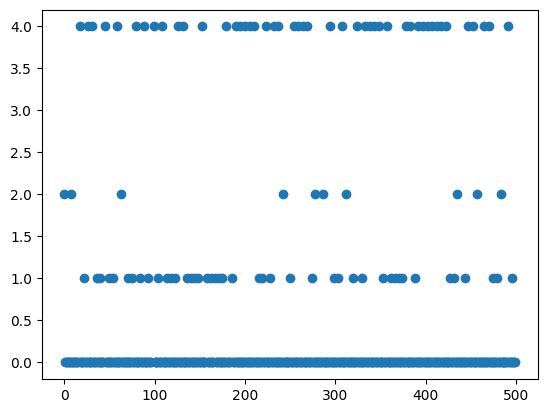

In [105]:
#plot the solution

plt.plot(solution['x'], solution["biscuit_type"], 'o')
plt.show()

## summary

- time to calculate : 16s to charge every constraints, 0.1s to solve the problem

- number of biscuit produced : 101

- value of biscuit produced : 760

- criteria are respected, as seen by the function defect_checker

- the solution is optimal